In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

df_train = pd.read_csv('train_ML.csv')
df_test = pd.read_csv('test_ML.csv')
df_test['is_pass'] = -1
df = pd.concat([df_train,df_test],ignore_index = True)
df

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104491,18820_22,T_3,T,134,22,offline,intermediate,18820,F,No Qualification,2,22.0,2,N,1.0,-1
104492,1641_96,V_1,V,133,96,offline,easy,1641,F,Matriculation,1,41.0,2,N,3.0,-1
104493,7010_157,Y_1,Y,136,157,online,easy,7010,M,Bachelors,2,NaN,3,N,4.0,-1
104494,14895_179,Z_1,Z,136,179,offline,easy,14895,F,Matriculation,3,NaN,1,N,1.0,-1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104496 entries, 0 to 104495
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         104496 non-null  object 
 1   program_id                 104496 non-null  object 
 2   program_type               104496 non-null  object 
 3   program_duration           104496 non-null  int64  
 4   test_id                    104496 non-null  int64  
 5   test_type                  104496 non-null  object 
 6   difficulty_level           104496 non-null  object 
 7   trainee_id                 104496 non-null  int64  
 8   gender                     104496 non-null  object 
 9   education                  104496 non-null  object 
 10  city_tier                  104496 non-null  int64  
 11  age                        64976 non-null   float64
 12  total_programs_enrolled    104496 non-null  int64  
 13  is_handicapped             10

In [3]:
# Verify few assumptions

df['new'] = df['program_id'].apply(lambda x: x[0])
df['new_id'] = df['id'].apply(lambda x: int(str(x).split('_')[1]))
print(df['new'].equals(df['program_type']))
print(df['new_id'].equals(df['test_id']))
df = df.drop(['new','new_id'],axis = 1)

True
True


In [4]:
# Mapping between test_id and program_id
prg_list = set(df['program_id'].unique())
prg_map_testid = dict()
for each in tqdm(prg_list):
    x=df[df['program_id']==each]
    prg_map_testid[each] = set(x['test_id'].unique())
prg_map_testid

100%|██████████| 22/22 [00:00<00:00, 41.26it/s]


{'S_1': {5, 6, 7, 8, 9},
 'X_2': {105, 106, 107, 108},
 'Y_4': {113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124},
 'X_1': {109, 110, 111, 112},
 'U_1': {57, 58, 59, 60, 61, 62, 63, 64, 65},
 'Y_3': {125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136},
 'T_4': {10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
 'Y_1': {149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160},
 'S_2': {0, 1, 2, 3, 4},
 'Z_3': {161, 162, 163, 164, 165, 166, 167, 168, 169},
 'T_3': {21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31},
 'Z_2': {170, 171, 172, 173, 174, 175, 176, 177, 178},
 'U_2': {48, 49, 50, 51, 52, 53, 54, 55, 56},
 'V_2': {87, 88, 89, 90, 91, 92, 93},
 'T_2': {32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42},
 'Z_1': {179, 180, 181, 182, 183, 184, 185, 186, 187},
 'V_3': {80, 81, 82, 83, 84, 85, 86},
 'V_4': {66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79},
 'T_1': {43, 44, 45, 46, 47},
 'Y_2': {137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148},
 'X_3': {101, 102, 

In [5]:
df['is_handicapped'] = df['is_handicapped'].replace('N',0).replace('Y',1)
df['test_type'] = df['test_type'].replace('offline',0).replace('online',1)
df['gender'] = df['gender'].replace('M',1).replace('F',0)
df['education'] = df['education'].replace('Matriculation',1).replace('High School Diploma',2).replace('Bachelors',3).replace('Masters',4).replace('No Qualification',0)

df['age'] = df['age'].fillna(-99)
df['trainee_engagement_rating'] = df['trainee_engagement_rating'].fillna(0)
#df['city_tier'] = df['city_tier'].astype('category') # Verify if this needs to be chaged to dummy variables
df

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,0,intermediate,9389,1,1,3,24.0,5,0,1.0,0
1,16523_44,T_1,T,131,44,0,easy,16523,0,2,4,26.0,2,0,3.0,1
2,13987_178,Z_2,Z,120,178,1,easy,13987,1,1,1,40.0,1,0,2.0,1
3,13158_32,T_2,T,117,32,0,easy,13158,0,1,3,-99.0,4,0,1.0,1
4,10591_84,V_3,V,131,84,0,intermediate,10591,0,2,1,42.0,2,0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104491,18820_22,T_3,T,134,22,0,intermediate,18820,0,0,2,22.0,2,0,1.0,-1
104492,1641_96,V_1,V,133,96,0,easy,1641,0,1,1,41.0,2,0,3.0,-1
104493,7010_157,Y_1,Y,136,157,1,easy,7010,1,3,2,-99.0,3,0,4.0,-1
104494,14895_179,Z_1,Z,136,179,0,easy,14895,0,1,3,-99.0,1,0,1.0,-1


In [6]:
protype_dict = df_train.groupby(['program_type'])['is_pass'].mean().to_dict()
protype_dict

{'S': 0.5460030165912518,
 'T': 0.6987214216058077,
 'U': 0.6252397391637898,
 'V': 0.585873320537428,
 'X': 0.8140024038461539,
 'Y': 0.7640957446808511,
 'Z': 0.7207723638557851}

In [7]:
df['program_type'] = df['program_type'].replace('S',protype_dict['S']).replace('T',protype_dict['T']).replace('U',protype_dict['U']).replace('V',protype_dict['V']).replace('Z',protype_dict['Z']).replace('X',protype_dict['X']).replace('Y',protype_dict['Y'])
df['program_type']

0         0.764096
1         0.698721
2         0.720772
3         0.698721
4         0.585873
            ...   
104491    0.698721
104492    0.585873
104493    0.764096
104494    0.720772
104495    0.814002
Name: program_type, Length: 104496, dtype: float64

In [8]:
dummies = pd.get_dummies(df['difficulty_level'])
dummies = dummies.drop(['vary hard'],axis = 1)
edu = pd.get_dummies(df['education'])
df = pd.concat([df,dummies],axis = 1)
df = df.drop(['difficulty_level','trainee_id'],axis = 1)
df

,id,program_id,program_type,program_duration,test_id,test_type,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,easy,hard,intermediate
0,9389_150,Y_1,0.764096,136,150,0,1,1,3,24.0,5,0,1.0,0,0,0,1
1,16523_44,T_1,0.698721,131,44,0,0,2,4,26.0,2,0,3.0,1,1,0,0
2,13987_178,Z_2,0.720772,120,178,1,1,1,1,40.0,1,0,2.0,1,1,0,0
3,13158_32,T_2,0.698721,117,32,0,0,1,3,-99.0,4,0,1.0,1,1,0,0
4,10591_84,V_3,0.585873,131,84,0,0,2,1,42.0,2,0,4.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104491,18820_22,T_3,0.698721,134,22,0,0,0,2,22.0,2,0,1.0,-1,0,0,1
104492,1641_96,V_1,0.585873,133,96,0,0,1,1,41.0,2,0,3.0,-1,1,0,0
104493,7010_157,Y_1,0.764096,136,157,1,1,3,2,-99.0,3,0,4.0,-1,1,0,0
104494,14895_179,Z_1,0.720772,136,179,0,0,1,3,-99.0,1,0,1.0,-1,1,0,0


In [9]:
mylist = []
for index, row in tqdm(df.iterrows()):
    mylist.append(str(str(row['program_id'])+'_'+str(row['test_id'])))

104496it [00:29, 3533.45it/s]


In [10]:
x = pd.Series(mylist)
df = pd.concat([df,x],axis = 1)
df

,id,program_id,program_type,program_duration,test_id,test_type,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,easy,hard,intermediate,0
0,9389_150,Y_1,0.764096,136,150,0,1,1,3,24.0,5,0,1.0,0,0,0,1,Y_1_150
1,16523_44,T_1,0.698721,131,44,0,0,2,4,26.0,2,0,3.0,1,1,0,0,T_1_44
2,13987_178,Z_2,0.720772,120,178,1,1,1,1,40.0,1,0,2.0,1,1,0,0,Z_2_178
3,13158_32,T_2,0.698721,117,32,0,0,1,3,-99.0,4,0,1.0,1,1,0,0,T_2_32
4,10591_84,V_3,0.585873,131,84,0,0,2,1,42.0,2,0,4.0,1,0,0,1,V_3_84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104491,18820_22,T_3,0.698721,134,22,0,0,0,2,22.0,2,0,1.0,-1,0,0,1,T_3_22
104492,1641_96,V_1,0.585873,133,96,0,0,1,1,41.0,2,0,3.0,-1,1,0,0,V_1_96
104493,7010_157,Y_1,0.764096,136,157,1,1,3,2,-99.0,3,0,4.0,-1,1,0,0,Y_1_157
104494,14895_179,Z_1,0.720772,136,179,0,0,1,3,-99.0,1,0,1.0,-1,1,0,0,Z_1_179


In [11]:
df.columns = ['id','program_id','program_type','program_duration','test_id','test_type','gender','education','city_tier','age',
'total_programs_enrolled','is_handicapped','trainee_engagement_rating','is_pass','easy','hard','intermediate','final_id']
df = df.drop(['program_id','test_id'],axis = 1)

In [12]:
code_dict = df[df['is_pass']!= -1].groupby('final_id')['is_pass'].mean().to_dict()

In [13]:
df['final_id'] = df['final_id'].map(code_dict)

In [14]:
df = df[['id', 'program_type', 'program_duration', 'test_type', 'gender',
       'education', 'city_tier', 'age', 'total_programs_enrolled',
       'is_handicapped', 'trainee_engagement_rating','easy',
       'hard', 'intermediate', 'final_id','is_pass']]


In [15]:
pr_df_train = df[df['is_pass'] != -1].drop('id',axis = 1)
pr_df_validate = df[df['is_pass'] == -1].drop(['id','is_pass'],axis = 1)

In [16]:
m,n=pr_df_train.shape
m,n

(73147, 15)

In [17]:
X = pr_df_train.iloc[:,0:n-1].values
y = pr_df_train.iloc[:,-1].values
X,y

(array([[  0.76409574, 136.        ,   0.        , ...,   0.        ,
           1.        ,   0.75562219],
        [  0.69872142, 131.        ,   0.        , ...,   0.        ,
           0.        ,   0.46363636],
        [  0.72077236, 120.        ,   1.        , ...,   0.        ,
           0.        ,   0.81547619],
        ...,
        [  0.76409574, 120.        ,   1.        , ...,   0.        ,
           0.        ,   0.87128713],
        [  0.58587332, 131.        ,   0.        , ...,   0.        ,
           1.        ,   0.76571429],
        [  0.76409574, 121.        ,   1.        , ...,   0.        ,
           0.        ,   0.93285372]]),
 array([0, 1, 1, ..., 1, 1, 1], dtype=int64))

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [19]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((51202, 14), (21945, 14), (51202,), (21945,))

In [20]:
clf = RandomForestClassifier(random_state = 41)
clf.fit(X_train,y_train)
print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

Accuracy on train: 0.9510956603257685
Accuracy on test: 0.7103212576896788


## Feature Importance Plot

<BarContainer object of 14 artists>

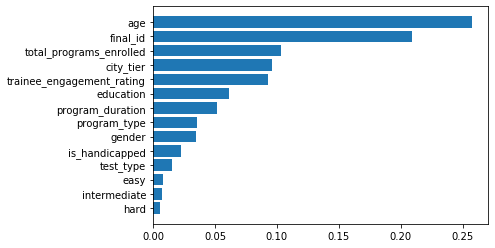

In [37]:
fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

## Random forest implmentation

In [38]:
with mlflow.start_run():
    clf = RandomForestClassifier(n_estimators=200,random_state = 41)
    clf.fit(X_train,y_train)

    print('Accuracy on train:',clf.score(X_train,y_train))
    print('Accuracy on test:',clf.score(X_test,y_test))

    X_val = pr_df_validate.values
    y_pred = clf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('Output.csv')

    print('Feature Importance:', clf.feature_importances_)

    mlflow.log_param('random state', 41)
    mlflow.log_param('n_estimators', 200)
    mlflow.log_metric('accuracy', clf.score(X_test,y_test))

Accuracy on train: 0.9510956603257685
Accuracy on test: 0.7134199134199134
Feature Importance: [0.03584395 0.05176378 0.01533577 0.03438013 0.0616332  0.09471031
 0.25605186 0.10415547 0.02300527 0.09188582 0.00796224 0.00536477
 0.00753942 0.21036803]


## Random forest Fine Tuning

In [39]:
parameters = [{'criterion' : ['gini','entropy'],
               'max_depth' : [5,6,7],
               'n_estimators' : [100,125,150,175,200]}]

grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True),
                           scoring = 'accuracy',
                           n_jobs = -1
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_

({'criterion': 'gini', 'max_depth': 7, 'n_estimators': 150},
 0.7225303391392442)

In [40]:
with mlflow.start_run():
    clf = RandomForestClassifier(n_estimators=100,random_state = 41,max_depth = 7,criterion = 'gini')
    clf.fit(X_train,y_train)
    
    print('Accuracy on train:',clf.score(X_train,y_train))
    print('Accuracy on test:',clf.score(X_test,y_test))
    
    y_pred = clf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('Output_1.csv')
    
    print('Feature Importance:', clf.feature_importances_)
    
    mlflow.log_param('random state', 41)
    mlflow.log_param('n_estimators', 100)
    mlflow.log_param('max_depth', 7)
    mlflow.log_param('criterion', 'gini')
    mlflow.log_metric('accuracy', clf.score(X_test,y_test))

Accuracy on train: 0.7275887660638256
Accuracy on test: 0.7247664616085668
Feature Importance: [0.09699586 0.02375776 0.08066321 0.00679975 0.05098503 0.02386673
 0.02142458 0.01977208 0.00581583 0.22339988 0.02306489 0.00579715
 0.0079726  0.40968464]


<BarContainer object of 14 artists>

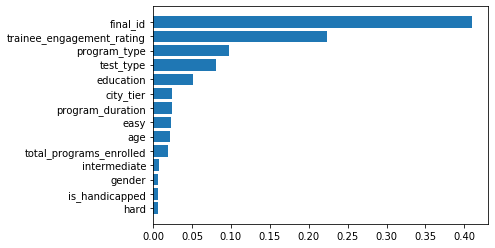

In [41]:
fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

## AdaBoost Implementation

In [42]:
with mlflow.start_run():
    clf = AdaBoostClassifier(random_state = 41)
    clf.fit(X_train,y_train)

    print('Accuracy on train:',clf.score(X_train,y_train))
    print('Accuracy on test:',clf.score(X_test,y_test))
    
    y_pred = clf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('Adaboost.csv')
    
    

Accuracy on train: 0.7260067966095074
Accuracy on test: 0.7301891091364776


In [43]:
mlflow.log_param('random state', 41)
mlflow.log_param('n_estimators', 200)
mlflow.log_metric('accuracy', clf.score(X_test,y_test))

In [44]:
mlflow.end_run()

<BarContainer object of 14 artists>

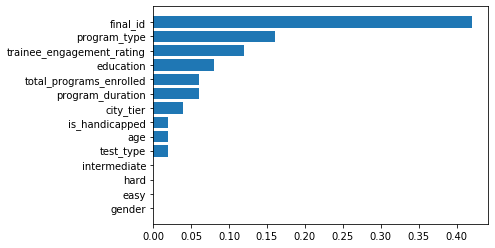

In [45]:
fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [46]:
parameters = [{'learning_rate' : [0.2,0.4,0.6,0.75,1],
               'n_estimators' : [150,200,225,250]}]
grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_

({'learning_rate': 1, 'n_estimators': 200}, 0.7283895100728688)

Accuracy on train: 0.7288973086988789
Accuracy on test: 0.7297789929368876


<BarContainer object of 14 artists>

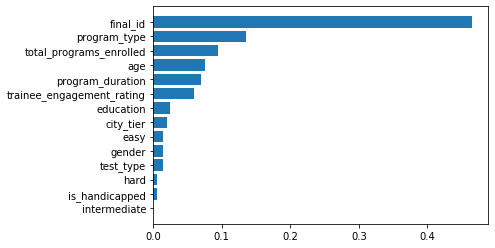

In [48]:
with mlflow.start_run():
    clf = AdaBoostClassifier(n_estimators = 200,random_state = 41,learning_rate = 1)
    clf.fit(X_train,y_train)
    
    print('Accuracy on train:',clf.score(X_train,y_train))
    print('Accuracy on test:',clf.score(X_test,y_test))
    
    y_pred = clf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('Adaboost_GCV.csv')
    
    mlflow.log_param('random state', 41)
    mlflow.log_param('n_estimators', 200)
    mlflow.log_metric('accuracy', clf.score(X_test,y_test))

fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

## XGBoosting

Accuracy on train: 0.7706339596109527
Accuracy on test: 0.7351105035315562


<BarContainer object of 14 artists>

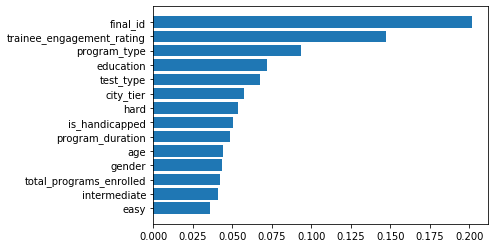

In [51]:
with mlflow.start_run():
    xgclf = XGBClassifier()
    xgclf.fit(X_train,y_train)
    
    print('Accuracy on train:',xgclf.score(X_train,y_train))
    print('Accuracy on test:',xgclf.score(X_test,y_test))
    
    y_pred = xgclf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('XGBoost.csv')
    
    mlflow.log_param('random state', 41)
    mlflow.log_param('n_estimators', 200)
    mlflow.log_metric('accuracy', xgclf.score(X_test,y_test))
    
fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,xgclf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

## Tuning

In [50]:
parameters = [{'learning_rate' : [0.4,0.6,0.75],
               'n_estimators' : [60,75,80],
               'max_depth' : [2,3,5]}]
grid_search = GridSearchCV(estimator = xgclf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 4, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_

({'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 60},
 0.7295027442314077)

Accuracy on train: 0.7731924534197883
Accuracy on test: 0.7334700387331966


<BarContainer object of 14 artists>

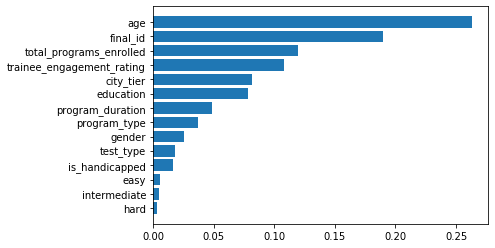

In [61]:
with mlflow.start_run():
    xgclf = XGBClassifier(max_depth = 5, n_estimators = 250)
    xgclf.fit(X_train,y_train)
    
    print('Accuracy on train:',xgclf.score(X_train,y_train))
    print('Accuracy on test:',xgclf.score(X_test,y_test))
    
    y_pred = xgclf.predict(X_val)
    pd.DataFrame(list(y_pred)).to_csv('XGBoost_GCV_2.csv')
    
    mlflow.log_param('random state', 41)
    mlflow.log_param('n_estimators', 200)
    mlflow.log_metric('accuracy', clf.score(X_test,y_test))
    
fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

#Accuracy on train: 0.7521776493105738
#Accuracy on test: 0.729915698336751

#Accuracy on train: 0.7627827038006327
#Accuracy on test: 0.7300979722032354

In [55]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

Accuracy on train: 0.9510956603257685
Accuracy on test: 0.6936887673729779


<BarContainer object of 14 artists>

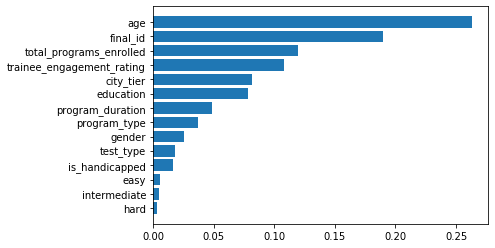

In [53]:
clf = ExtraTreesClassifier()
clf.fit(X_train,y_train)
print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))
    
y_pred = clf.predict(X_val)
pd.DataFrame(list(y_pred)).to_csv('Extra_trees.csv')

fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [42]:
ExtraTreesClassifier()

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [50]:
parameters = [{'max_features' : [14,15],
               'n_estimators' : [140,155,160],
               'max_depth' : [9,10,11]}]
grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_

({'max_depth': 10, 'max_features': 14, 'n_estimators': 160},
 0.7288385438281174)

In [51]:
clf = ExtraTreesClassifier(max_features = 14,n_estimators = 160,max_depth = 10)
clf.fit(X_train,y_train)
print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

y_pred = clf.predict(X_val)

pd.DataFrame(list(y_pred)).to_csv('Extra_trees_1.csv')

fimp = pd.DataFrame(zip(pr_df_train.drop('is_pass',axis = 1).columns,clf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

Accuracy on train: 0.7508105152142495
Accuracy on test: 0.7310549100022784


In [52]:
y_pred_proba = clf.predict_proba(X_val)
y_pred_proba

array([[0.4137784 , 0.5862216 ],
       [0.07213538, 0.92786462],
       [0.30371452, 0.69628548],
       ...,
       [0.20132898, 0.79867102],
       [0.43715926, 0.56284074],
       [0.30819761, 0.69180239]])

In [56]:
pd.DataFrame(list(y_pred_proba),columns = ['Extra_P_0','Extra_P_1'])

,Extra_P_0,Extra_P_1
0,0.413778,0.586222
1,0.072135,0.927865
2,0.303715,0.696285
3,0.707971,0.292029
4,0.631423,0.368577
...,...,...
31344,0.477663,0.522337
31345,0.185958,0.814042
31346,0.201329,0.798671
31347,0.437159,0.562841


In [62]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.random state,params.n_estimators,params.criterion,params.max_depth,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,8cb4553b72a647d9b0ef478e620e24c1,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:03:46.769000+00:00,2020-04-30 09:03:52.081000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
1,e5f93f81d8a640fe80a255fd88619a3e,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:03:26.595000+00:00,2020-04-30 09:03:31.586000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
2,1731a6615ed74562b6ad80ae1e80efa7,0,FAILED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:03:01.604000+00:00,2020-04-30 09:03:22.645000+00:00,NaN,None,None,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
3,d80604675a064b6e8dfbd4aaa3c3ad61,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:02:40.381000+00:00,2020-04-30 09:02:44.828000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
4,3e68420be9cd40488ff1a20d80f16b91,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:02:25.981000+00:00,2020-04-30 09:02:29.312000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
5,21f41fd6fce6460aaf05bb81fea610b2,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 09:01:53.180000+00:00,2020-04-30 09:01:56.142000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
6,192af114ddd14b4e8988f36d55e56024,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 08:38:53.883000+00:00,2020-04-30 08:38:55.842000+00:00,0.693689,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
7,d3a6dec068c94c669eeec56863ff27d8,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 08:32:42.227000+00:00,2020-04-30 08:32:44.223000+00:00,0.729779,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
8,13f167357a1948e4bff59ea4267ebeb8,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 08:29:29.727000+00:00,2020-04-30 08:29:33.174000+00:00,0.735111,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
9,f837179f572846dc995051eb1d720973,0,FINISHED,file:///C:/Users/mdevasish/Desktop/DS/Janta%20...,2020-04-30 08:27:05.753000+00:00,2020-04-30 08:27:09.017000+00:00,0.729779,41,200,None,None,mdevasish,C:\Users\mdevasish\anaconda3\lib\site-packages...,LOCAL
